# Исследование объявлений о продаже квартир

### Описание проекта

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Импорт данных и библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
balcony — число балконов  
ceiling_height — высота потолков (м)  
city_сenter_nearest — расстояние до центра города (м)  
days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
first_day_exposition — дата публикации  
floor — этаж  
floors_total — всего этажей в доме  
is_apartment — апартаменты (булев тип)  
kitchen_area — площадь кухни в квадратных метрах (м²)  
last_price — цена на момент снятия с публикации  
living_area — жилая площадь в квадратных метрах(м²)  
locality_name — название населённого пункта  
open_plan — свободная планировка (булев тип)  
parks_around3000 — число парков в радиусе 3 км  
parks_nearest — расстояние до ближайшего парка (м)  
ponds_around3000 — число водоёмов в радиусе 3 км  
ponds_nearest — расстояние до ближайшего водоёма (м)  
rooms — число комнат  
studio — квартира-студия (булев тип)  
total_area — площадь квартиры в квадратных метрах (м²)  
total_images — число фотографий квартиры в объявлении

### Вывод

1) Таблица содержит 23 699 строк, некоторые столбцы содержат пропущенные значения  
2) Типы данных столбцов соответствуют их содержимому, что говорит о корректных данных в этих столбцах, хотя некоторые типы не совсем корректны (например, is_apartment должно содержать булевые значения, а floors_total - целочисленные)  
3) Названия столбцов понятны и в целом корретны, кроме cityCenters_nearest  
4) По верхним строкам нет явно некорретных данных

### Шаг 2. Предобработка данных

#### Изменение названий столбцов

Название столбца cityCenters_nearest не соответсвует общему формату, обновляю его:

In [3]:
df.rename(columns={'cityCenters_nearest': 'city_сenter_nearest'}, inplace=True)

#### Изменение типов данных

1) Количество этажей должно быть целочисленным значением, проверяю, что нет вещественных, и меняю тип данных:

In [4]:
df['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [5]:
df['floors_total'] = df['floors_total'].astype('Int64')

2) Количество балконов должно быть целочисленным значением, проверяю, что нет вещественных, и меняю тип данных. Так как часть данных не заполнена, предполагаю, что эти квартиры не имеют балконов и заменяю пропущенные значения на 0.

In [6]:
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [7]:
df['balcony'] = df['balcony'].fillna(0)

In [8]:
df['balcony'] = df['balcony'].astype('Int64')

3) is_appartment должно быть булевым, проверяю значения:

In [9]:
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Так апартаменты продаются реже, чем жилые помещения, и должны прямо выделяться в объявлении, я предполагаю, что все незаполненные значения не являются апартаментами, заменяю значения и меняю тип данных:

In [10]:
df['is_apartment'].replace('True', True)
df['is_apartment'].replace('False', False)
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'] = df['is_apartment'].astype('bool')
df['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

4) days_exposition. Количество дней жизни объявления должно быть целочисленным значением, так как значений можнет быть много, не смотрю их все, а округляю и меняю тип данных.

In [11]:
df['days_exposition'] = df['days_exposition'].round()
df['days_exposition'] = df['days_exposition'].astype('Int64')

Остальные типы данных корректны.

#### Обработка значений данных

Проверяю все столбцы подряд, чтобы выявить и обработать некорректные или отсутствующие данные.

##### total_images

In [12]:
df['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37])

##### last_price

Для начала оцениваю популяцию на предмет того, что можно считать выбросами, поэтому ставлю перцентили в 1% и 10% снизу и сверху:

In [13]:
df['last_price'].describe(percentiles=[.01, .1, .5, .9, .99]).round()

count        23699.0
mean       6541549.0
std       10887013.0
min          12190.0
1%         1000000.0
10%        2500000.0
50%        4650000.0
90%       10914231.0
99%       36000000.0
max      763000000.0
Name: last_price, dtype: float64

В целом данные нормальные, среднее выше медианы и обе находятся в разумных пределах. Минимальное и максимальное значения похожи на некорретные. Лучше посмотреть на данные графически, ограничиваясь 1 и 99 перцентилем:

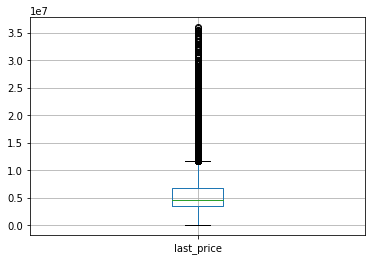

In [14]:
df[df['last_price']<36000000].boxplot(column=['last_price'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4faa61ca58>]],
      dtype=object)

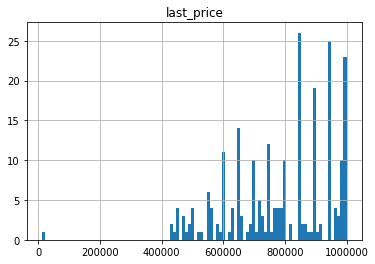

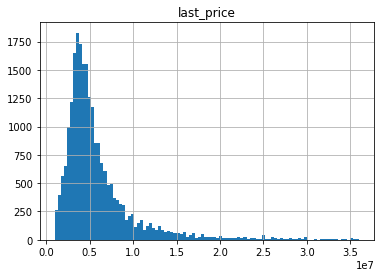

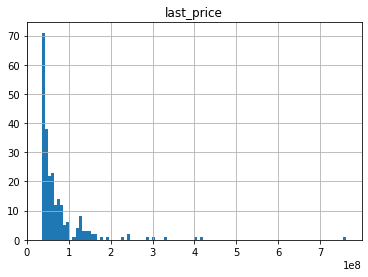

In [15]:
df.hist('last_price', bins=100, range=(df['last_price'].min(),10**6))
df.hist('last_price', bins=100, range=(10**6,36000000))
df.hist('last_price', bins=100, range=(36000000, df['last_price'].max()))

Снизу есть один выброс с одним явно некорректным минимальным значением в 12 190 рублей. Далее, несмотря на редкие значения, распределение нормальное с 400 тысяч до 100 миллионов рублей, свыше чего есть едининчые объекты.  
Для целей проекта можно отбросить дорогие квартиры, так как их ценообразование строится на других факторах, нежели у большинства квартир, и не может быть оценено на основе имеющихся данных. Поэтому для нормализации данных по столбцу цены можно оставить данные в пределах 1,5 межквартильного размаха от 1 и 3 квартиля. Перед этим я удаляю одно минимальное значение, которое попадает внутрь этого размаха, но явно некорректно. 

In [16]:
df = df[df['last_price'] > 20000]

q1 = df['last_price'].quantile(0.25)
q3 = df['last_price'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr
print(lower_limit, q1, q3, iqr, upper_limit)
df = df.query('last_price > @lower_limit and last_price < @upper_limit ')

-1700000.0 3400000.0 6800000.0 3400000.0 11900000.0


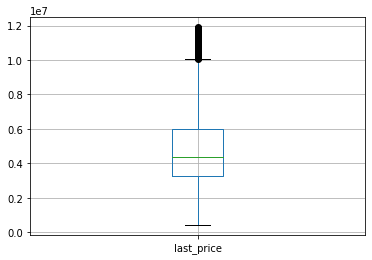

In [17]:
df.boxplot(column=['last_price'])

#### total_area, living_area, kitchen_area

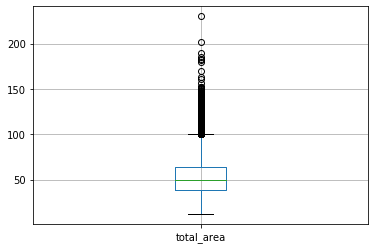

In [18]:
df.boxplot(column=['total_area'])

Несмотря на то, что у данных площади квартир длинный хвост, все значения находятся в пределах нормальных и объяснимых. Квартиры площадью больше 200 метров также должны укладываться в модель формирования стоимости, поэтому я оставляю все значения без изменений.  
Проверяю, что сумма жилой площади и площади кухни не превышает общую площадь квартиры:

In [19]:
df[df['total_area'] < df['living_area'] + df['kitchen_area']]['kitchen_area'].count()

61

Так как эти строки содержат явную ошибку, нельзя понять, в каком она из трех столбцов, и возможно, что остальные данные также заполнены неверно, а доля этих строк в общем количестве небольшая, я их удаляю:

In [20]:
df.drop(df[df['total_area'] < df['living_area'] + df['kitchen_area']].index, inplace=True)

Также в столбцах с жилой площадью и площадью кухни есть незаполеннные значения. Есть два возможных варианта работы с ними:  
а) заполнить пропущенные значения, основываясь на общей площади квартиры и среднем соотношении жилой площади и площади кухни к площади квартиры, и  
б) заполнить пропущенные значения нулями.  
Данные могут быть не заполнены по определенной причине, например, в квартире нет кухни; эти данные вторичны по отношению к общей площади и для анализа может быть важно только соотношение между жилой площадью или площадью кухни к общей площади, а оно в любом случае изначально неизвестно, поэтому я выбираю второй вариант:  

In [21]:
df['living_area'] = df['living_area'].fillna(0)
df['kitchen_area'] = df['kitchen_area'].fillna(0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21576 entries, 1 to 23698
Data columns (total 22 columns):
total_images            21576 non-null int64
last_price              21576 non-null float64
total_area              21576 non-null float64
first_day_exposition    21576 non-null object
rooms                   21576 non-null int64
ceiling_height          13049 non-null float64
floors_total            21502 non-null Int64
living_area             21576 non-null float64
floor                   21576 non-null int64
is_apartment            21576 non-null bool
studio                  21576 non-null bool
open_plan               21576 non-null bool
kitchen_area            21576 non-null float64
balcony                 21576 non-null Int64
locality_name           21533 non-null object
airports_nearest        16094 non-null float64
city_сenter_nearest     16105 non-null float64
parks_around3000        16106 non-null float64
parks_nearest           6706 non-null float64
ponds_around3000    

#### first_day_exposition

Столбец даты представлен типом object, изменяю на datetime:

In [23]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### rooms

In [24]:
df['rooms'].value_counts()

1    7975
2    7579
3    4934
4     758
0     195
5     118
6      16
7       1
Name: rooms, dtype: int64

Все значения корректны; предполагаю, что 0 - это квартиры-студии, проверяю:

In [25]:
df.pivot_table (index = ['rooms'], columns = 'studio', values = 'total_images', aggfunc='count')

studio,False,True
rooms,,
0,58.0,137.0
1,7964.0,11.0
2,7579.0,NaN
3,4934.0,NaN
4,758.0,NaN
5,118.0,NaN
6,16.0,NaN
7,1.0,NaN


Очевидно, не все данные заполнены корректно. Считаю, что все квартиры с нулевым количеством комнат и/или studio = True - студии, и исправляю данные:

In [26]:
df.loc[(df['rooms'] == 0) & (df['studio'] == False), 'studio'] = True
df.loc[(df['studio'] == True) & (df['rooms'] == 0), 'rooms'] = 1

In [27]:
df.pivot_table (index = ['rooms'], columns = 'studio', values = 'total_images', aggfunc='count')

studio,False,True
rooms,,
1,7964.0,206.0
2,7579.0,NaN
3,4934.0,NaN
4,758.0,NaN
5,118.0,NaN
6,16.0,NaN
7,1.0,NaN


#### floors_total & floors

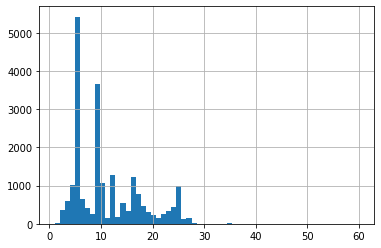

In [28]:
df['floors_total'].hist(bins=df['floors_total'].max())

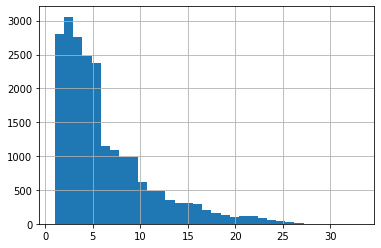

In [29]:
df['floor'].hist(bins=df['floor'].max())

In [30]:
df[df['floors_total'] < df['floor']]['floor'].count()

0

Во-первых, распределение floors_total ожидаемое (хоть и статистически ненормальное) с явными пиками пяти- и девяти- этажек. Во-вторых, распределение floor нормальное. В-третьих, ни для одной квартиры этаж  не превышает количество этажей в здании.  
Высота самого высокого жилого здания в Петербурге и окресностях - 37 этажей. Все значения выше этого можно заменить на значения этажа самой квартиры. Аналогично заменяю пропущенные значения floors_total:

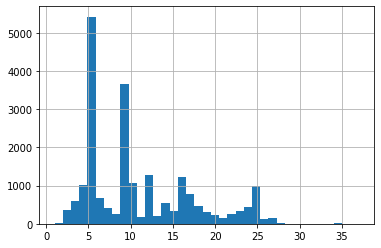

In [31]:
df['floors_total'] = np.where(df['floors_total'] > 37, df['floor'], df['floors_total'])
df['floors_total'] = np.where(df['floors_total'].isnull(), df['floor'], df['floors_total'])
df['floors_total'].hist(bins=df['floors_total'].max())

#### ceiling_height

Проверяю, какие значения представлены в столбце:

In [32]:
df['ceiling_height'].round().value_counts().sort_values()

23.0       1
10.0       1
20.0       1
14.0       1
26.0       1
6.0        1
24.0       1
1.0        2
32.0       2
5.0        3
8.0        4
27.0       7
25.0       7
4.0      194
2.0     3547
3.0     9276
Name: ceiling_height, dtype: int64

Очевидно, значения выше 6 метров некорректны. Нужно также проверить, где проходит нижняя граница, не округляя значения: 

In [33]:
df[df['ceiling_height']<2.5]['ceiling_height'].value_counts().sort_values()

2.20     1
1.20     1
2.49     1
2.34     1
1.00     1
2.25     1
1.75     1
2.46     2
2.47     3
2.30     4
2.48     8
2.00    10
2.45    15
2.40    23
Name: ceiling_height, dtype: int64

Исходя из полученных значений, считаю корректными высоту потолков от 2 до 6 метров включительно. Также в столбце есть пропущенные значения. Заменяю все некорректные и пропущенные значения на медиану корректных значений. Для этого я определяю, есть ли отличия высоты потолков в зависимости от высоты здания:

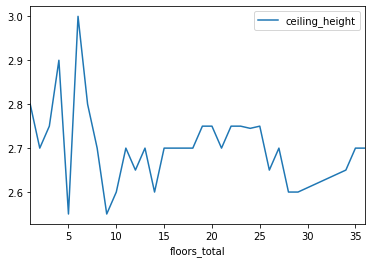

In [34]:
(df.query('ceiling_height >= 2 & ceiling_height <= 6')
 .pivot_table(index = ['floors_total'], values = 'ceiling_height', aggfunc = 'median')
 .plot(kind = 'line'))

На графике видны 3 группы зданий:  
- пяти- и девяти- этажки, среди которых большинство - хрущевки с высотой потолка в ~2,55 м;
- остальные здания до 9 этажей с более высоким потолком, по-видимому, старые в центре Петерубрга и пригородов; 
- новые здания от 10 этажей.  
Кроме объяснимых скачков для 5 и 9 этажей, остальные значения нормальные, поэтому можно заменить пропущенные и некорректные значения высоты потолков на медианные для каждой группы домов одинаковой этажности:

In [35]:
med_ceiling_general = df.query('ceiling_height >= 2 & ceiling_height<=6')['ceiling_height'].median()

for floor in range (df['floors_total'].min(), df['floors_total'].max()+1):
# если есть хотя бы одно объявление с выбранным количеством этажей и нормальной высотой полотков:
    if len(df.query('floors_total == @floor & ceiling_height >= 2 & ceiling_height<=6'))>0:
# исправляю неправильную высоту потолков на медиану для каждой группы домов одинаковой этажности:
        med_ceiling_per_floor = df.query('floors_total == @floor & ceiling_height >= 2 & ceiling_height<=6')['ceiling_height'].median()
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'] < 2), 'ceiling_height'] = med_ceiling_per_floor
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'] > 6), 'ceiling_height'] = med_ceiling_per_floor
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'].isnull()), 'ceiling_height'] = med_ceiling_per_floor
# если объявлений с выбранным количеством этажей и нормальной высотой полотков нет,
    else:
# исправляю неправильную высоту потолков на общую медиану:
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'] < 2), 'ceiling_height'] = med_ceiling_general
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'] > 6), 'ceiling_height'] = med_ceiling_general
        df.loc[(df['floors_total'] == floor) & (df['ceiling_height'].isnull()), 'ceiling_height'] = med_ceiling_general

Проверяю, что не осталось некорректных или пустых значений, а график высоты потолков по этажам не изменился:

In [36]:
print(len(df[df['ceiling_height']<2]))
print(len(df[df['ceiling_height']>6]))
print(df['ceiling_height'].isnull().sum())

0
0
0


In [37]:
df['ceiling_height'].round().value_counts().sort_values(ascending = False)

3.0    17832
2.0     3546
4.0      194
5.0        3
6.0        1
Name: ceiling_height, dtype: int64

#### locality_name

In [38]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург      13700
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             394
Пушкин                 338
Колпино                335
посёлок Парголово      326
Гатчина                301
деревня Кудрово        298
Выборг                 236
Name: locality_name, dtype: int64

Статусы населенных пунктов (например, поселок) могут присутствовать или отсутствовать в названии, а сам населенный пункт может менять статус и писаться по-разному с учетом ёфикации. Чтобы избежать различных написаний пунктов при группировке, я убираю все подобные статусы из названий в новый столбец: 

In [39]:
df['locality_name'] = df['locality_name'].str.strip()

statuses = ['поселок ', 'посёлок ', 'коттеджный поселок', 'коттеджный посёлок', 'деревня ', 
            'городской ', 'городского типа ', 'садовое товарищество ', 'село ']
for status in statuses:
    df['locality_name'] = df['locality_name'].str.replace(status, '')
df['locality_name'].value_counts().head(10)

Санкт-Петербург    13700
Мурино               587
Кудрово              470
Шушары               439
Всеволожск           394
Пушкин               338
Колпино              335
Парголово            326
Гатчина              301
Выборг               236
Name: locality_name, dtype: int64

Столбец стал информативнее, например, Кудрово переместилось с 9 на 3 место. Проверяю пропущенные значения:

43


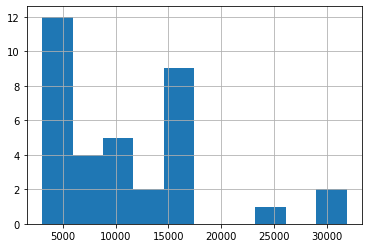

In [40]:
print(df[df['locality_name'].isnull()]['total_images'].count())
df[df['locality_name'].isnull()]['city_сenter_nearest'].hist()

Расстояние от центра города разное; однозначно определить, к какому городу относятся пропуски, нельзя; их количество (43) небольшое. Так как название населенного пункта важно для анализа, я удаляю эти строки:

In [41]:
df.dropna(subset = ['locality_name'], inplace = True)

#### airports_nearest & city_сenter_nearest     

Количество пропущенных значений: 5474


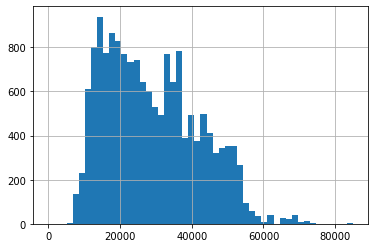

In [42]:
df['airports_nearest'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(df[df['airports_nearest'].isnull()]['total_images'].count()))

Распределение ожидаемое (нормальным оно быть не должно), интересны, во-первых, квартиры, удаленные более чем на 60 км:

In [43]:
df[df['airports_nearest'] > 60000]['locality_name'].value_counts()

Кронштадт      94
Парголово      30
Зеленогорск    22
Сестрорецк     14
Молодёжное      5
Репино          3
Щеглово         1
Name: locality_name, dtype: int64

Эти города действительно дальше всего от аэропорта. Во-вторых, нужно проверить пропущенные значения: 

In [44]:
df[df['airports_nearest'].isnull()]['locality_name'].value_counts()

Мурино                                                     585
Кудрово                                                    470
Всеволожск                                                 394
Гатчина                                                    301
Выборг                                                     236
                                                          ... 
Реброво                                                      1
Новая Ропша                                                  1
при железнодорожной станции Вещево                           1
садоводческое некоммерческое товарищество Лесная Поляна      1
Большое Рейзино                                              1
Name: locality_name, Length: 290, dtype: int64

Пропущенные значения есть только для отдельных населенных пунктов. Вероятно, заполнить их можно будет так же, как и пропущенные значения расстояния до центра города, поэтому сейчас я перехожу к нему:

Количество пропущенных значений: 5463


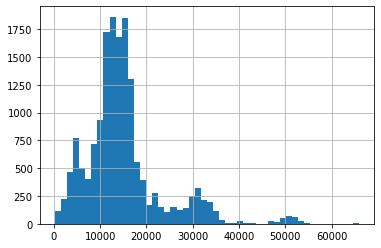

In [45]:
df['city_сenter_nearest'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(df[df['city_сenter_nearest'].isnull()]['total_images'].count()))

In [46]:
df[df['city_сenter_nearest'].isnull()]['locality_name'].value_counts()

Мурино                585
Кудрово               470
Всеволожск            394
Гатчина               301
Выборг                236
                     ... 
Цвылёво                 1
Снегирёвка              1
Алексеевка              1
коттеджный Счастье      1
Дружноселье             1
Name: locality_name, Length: 291, dtype: int64

Пропуски airport_nearest и city_сenter_nearest по большей части совпадают. Проверяю, есть ли в городах с пропущенными значениями строки с заполненными значениями:

In [47]:
localities_NaN_airport_center = (
    df.query('airports_nearest != airports_nearest and city_сenter_nearest != city_сenter_nearest')
    ['locality_name'].unique())
print(len(localities_NaN_airport_center))
print(len((
    df[(df['locality_name'].isin(localities_NaN_airport_center)) 
    & (df['airports_nearest'].notnull())]['locality_name'].unique())))
print(len((
    df[(df['locality_name'].isin(localities_NaN_airport_center)) 
    & (df['city_сenter_nearest'].notnull())]['locality_name'].unique())))
print((
    df[(df['locality_name'].isin(localities_NaN_airport_center)) 
    & (df['airports_nearest'].notnull())]['locality_name'].unique()))

290
8
8
['Шушары' 'Санкт-Петербург' 'Ломоносов' 'Колпино' 'Кронштадт'
 'Красное Село' 'Щеглово' 'Мурино']


Для квартир в 290 населенных пунктах не указано расстояние до центра города и аэропорта. При этом только в 8 из них есть другие квартиры, для которых такие расстояния указаны, и эти населенные пункты совпадают и для расстояния до центра города, и для аэропорта. Восстановить эти данные на основе данных датасета нельзя, заполнять другими значениями нет смысла, потому что они будут искажать выводы при анализе влияния расстояния до центра на остальные параметры. Чтобы пропущенные данные не влияли на расчеты, я оставляю их в формате NaN. 

#### parks_around3000, parks_nearest, ponds_around3000, ponds_nearest

Предполагаю, что пропущенные значения расстояния до ближайшего парка и водоема означают, что в пределах 3 км нет парков и водоемов:

In [48]:
df[df['parks_nearest'].isnull()]['parks_around3000'].value_counts()

0.0    9375
Name: parks_around3000, dtype: int64

In [49]:
df[df['ponds_nearest'].isnull()]['ponds_around3000'].value_counts()

0.0    8334
Name: ponds_around3000, dtype: int64

Предположение подтвердилось. NaN - корректное значение, его можно оставить и не заменять. Смотрю значения количества парков и водоемов и их распределение:

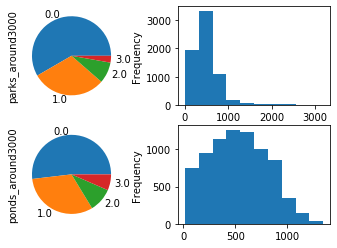

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df['parks_around3000'].value_counts().plot(kind='pie', ax=axes[0, 0]);
df['parks_nearest'].plot(kind='hist', ax=axes[0, 1]);
df['ponds_around3000'].value_counts().plot(kind='pie', ax=axes[1, 0]);
df['ponds_nearest'].plot(kind='hist', ax=axes[1, 1]);

Распределение всех величин нормальное. Так как дело происходит в Петербурге, количество водоемов превышает количество парков, и, если рядом есть водоем, то он находится в пределах 1,5 км. 
Вывод: значения корректны, пропущенные значения заполнять не нужно.

#### days_exposition

Количество пропущенных значений: 2628


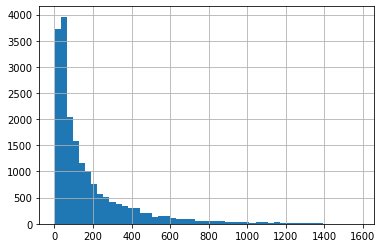

In [51]:
df['days_exposition'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(df[df['days_exposition'].isnull()]['total_images'].count()))

За счет большого хвоста большая часть значений сливается.

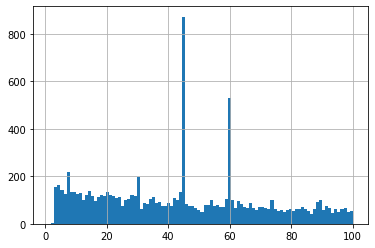

In [52]:
df[df['days_exposition'] <= 100]['days_exposition'].hist(bins = 100)

In [53]:
df.groupby('days_exposition')['days_exposition'].count().sort_values(ascending=False).head()

days_exposition
45    872
60    531
7     220
30    197
4     164
Name: days_exposition, dtype: int64

Исходя из предположения, что пики на 30, 45 и 60 днях - это автоматическое закрытие объявлений после периода неактивности, эти значения искажают данные по срокам закрытия объявлений. При этом неизвестно, объявление было удалено автоматически, так как его владелец не смог продать квартиру и забыл про него (в этом случае срок продажи дольше жизни объявления), или, наоборот, продал квартиру до автоматического удаления (то есть срок продажи меньше срока жизни объявления), поэтому нельзя заменить пиковые значения на другие. Замена на медиану приведет к сильному искажению популяции. Строки с пиковыми значениями можно удалить из популяции, но время закрытия объявления не является одним из основных параметров, поэтому сокращение популяции более чем на тысячу строк ради этого столбца неоправданно. Поэтому я удаляю такие пиковые значения из столбца, таким образом, популяция не сократится, а некорректные значения не будут влиять на расчеты в дальнейшем. 

In [54]:
df.loc[df['days_exposition'] == 30, 'days_exposition'] = np.NaN
df.loc[df['days_exposition'] == 45, 'days_exposition'] = np.NaN
df.loc[df['days_exposition'] == 60, 'days_exposition'] = np.NaN

Количество пропущенных значений: 4228


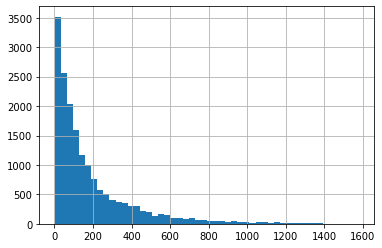

In [55]:
df['days_exposition'].hist(bins = 50)
print('Количество пропущенных значений: {:.0f}'.format(df[df['days_exposition'].isnull()]['total_images'].count()))

Количество остальных пропущенных значений говорит о том, что они неслучайны, скорее всего, эти объявления не закрыты, то есть квартира или еще продается, или владелец объявления забыл его снять. За исключением убранных пиковых значений, распределение нормальное, поэтому данные можно использовать, больше изменений не требуется. 

#### Проверка дубликатов

In [56]:
df.duplicated().sum()

0

Дубликатов не выявлено.

### Шаг 3. Расчет и добавление показателей

#### Цена квадратного метра

In [57]:
df['price_per_sqm'] = df['last_price'] / df['total_area']
df['price_per_sqm'] = df['price_per_sqm'].round(2)

#### День недели, месяц и год публикации объявления

In [58]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

#### Этаж квартиры

In [59]:
df['floor_type'] = np.where(df['floor'] == 1, 'первый', 'другой')
df['floor_type'] = np.where(df['floor'] == df['floors_total'], 'последний', df['floor_type'])

<font color='green'>Хорошо, молодец, что используешь where().

#### Соотношение жилой и общей площади, а также отношение площади кухни к общей

In [60]:
df['living_area_rel'] = df['living_area'] / df['total_area']
df['kitchen_area_rel'] = df['kitchen_area'] / df['total_area']

<font color='green'>Можно приступать к анализу!

### Шаг 4. Исследовательский анализ данных

#### Площадь, цена, количество комнат и высота потолков
Гистограммы:

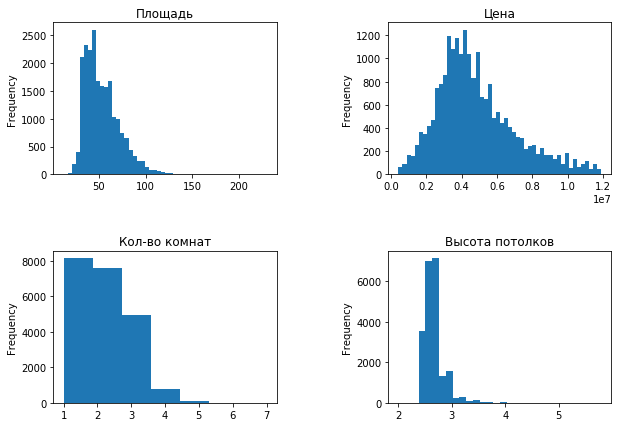

In [61]:
columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']
titles = ['Площадь', 'Цена', 'Кол-во комнат', 'Высота потолков']
bins_number = [50, 50, df['rooms'].max(), 30]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,7))
fig.subplots_adjust(wspace=0.5, hspace = 0.5)
for i in range (len(columns)):
    df[columns[i]].plot(kind='hist', bins = bins_number[i], ax =ax[i//2, (i)%2], title=titles[i]);
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fa9ac3ac8>,
      dtype=object)

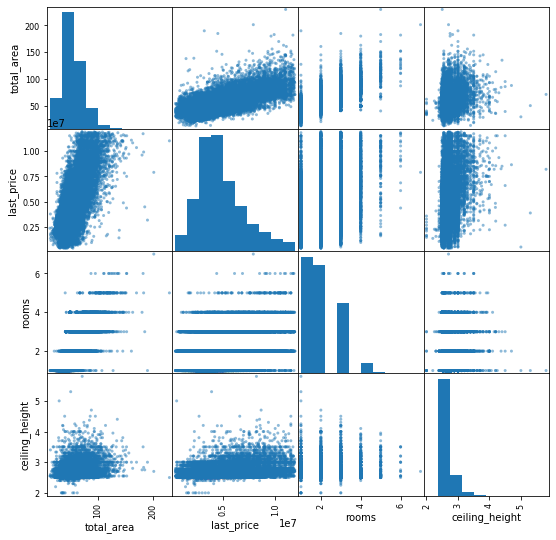

In [62]:
pd.plotting.scatter_matrix(df.loc[:,['total_area','last_price','rooms','ceiling_height']], figsize=(9, 9), alpha = 0.5)

Из распределений выше видно, что:  
- есть определенная связь между площадью и стоимостью квартиры, которая будет отдельно разобрана ниже,  
- прямая связь площади и количества комнат, однако не настолько очевидная, как можно ожидать: есть как одно-, так и пяти-комнатные квартиры площадью 100 метров, а трех- и четырехкомнатные квартиры лежат примерно в одном диапазоне,  
- стоимость и количество комнат положительно коррелируют, так как связаны с площадью,  
- а высота потолков имеет небольшой разброс и почти не связана с другими параметрами (в маленьких квартирах больше разброс высоты потолков просто потому, что их больше, чем больших квартир).  
  
График площади и стоимости квартир с ограничением до 90% квантиля:

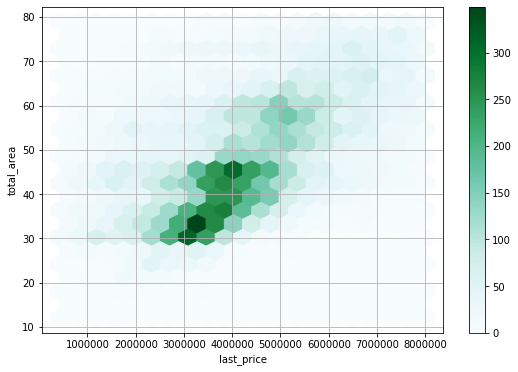

In [63]:
price_qnt = df['last_price'].quantile(0.9)
area_qnt = df['total_area'].quantile(0.9)
df.query('last_price < @price_qnt and total_area < @area_qnt').plot(x='last_price', y='total_area', kind='hexbin', gridsize=20, figsize=(9, 6), sharex=False, grid=True)

На этом графике видно, что:  
- площадь большинства квартир сосредоточена в пределах от 30 до 50 метров,
- у квартир в любом диапазоне при одинаковой площади стоимость отличается примерно в 1,5 раза,
- есть очевидная связь между стоимостью и площадью квартиры.

#### Время выставления объявления  
На графиках ниже показаны:  
- в верхней строке - время (день, месяц, год) публикации объявления,
- в нижней строке - медианное время, которое это объявление было открыто.

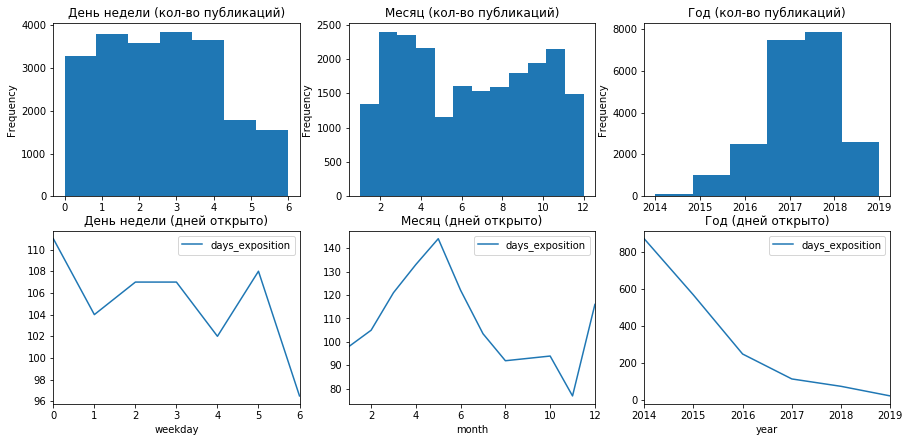

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
df['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
df['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
df['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
df.pivot_table(index=['weekday'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'День недели (дней открыто)');
df.pivot_table(index=['month'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Месяц (дней открыто)');
df.pivot_table(index=['year'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Год (дней открыто)');

#### Вывод:
Как видно, по будням публикуется больше объявлений, чем в выходные, так как этим занимаются профессиональные риелторы. На время закрытия это почти не влияет.  
По месяцам больше всего объявлений появляется с февраля по апрель, чуть меньше - с сентября по ноябрь. Это может быть связано с общим количеством рабочих дней и активности: меньше всего объявлений в периоды праздников (декабрь, январь, май, и летних отпусков). Примерно такая же тенденция с закрытием объявлений: объявления, опубликованные в месяцы меньшей активности, закрываются дольше.  
По годам есть прямая взаимосвязь, с развитием сервиса объявлений публикуется больше и они закрываются быстрее.  
Также нужно учитывать, что на нижних графиках отражены только закрытые объявления.  
Для того, чтобы корректно учесть медианное время закытия объявления, лучше брать данные только с 2017 года, так как до этого этот показатель был значительно больше:

In [65]:
print('Медианное время закрытия объявления с 2017 года: {:.0f} дней.'.format(df.query('year > 2016')['days_exposition'].median()))
print('Среднее время закрытия объявления с 2017 года: {:.0f} дней.'.format(df.query('year > 2016')['days_exposition'].mean()))

Медианное время закрытия объявления с 2017 года: 82 дней.
Среднее время закрытия объявления с 2017 года: 125 дней.


#### Факторы, влияющие на стоимость квартиры
Как показано выше, стоимость квартиры положительно коррелирует с ее площадью. Поэтому для оценки факторов влияния на стоимость нужно сравнивать стоимость квадратного метра площади в зависимости от других параметров:  
(от стоимости отрезано по 10% значений сверху и снизу для наглядности графиков)

In [66]:
price_per_sqm_qntl = df['price_per_sqm'].quantile(0.9)
price_per_sqm_qntu = df['price_per_sqm'].quantile(0.1)
total_area_qnt = df['total_area'].quantile(0.9)
city_сenter_nearest_qnt = df['city_сenter_nearest'].quantile(0.9)

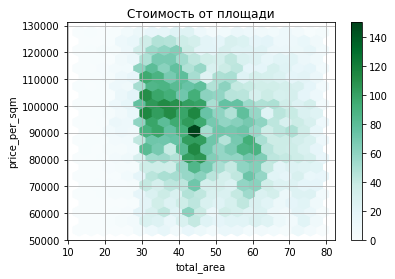

In [67]:
(df.query('price_per_sqm < @price_per_sqm_qntl and price_per_sqm > @price_per_sqm_qntu and total_area < @total_area_qnt')
 .plot(x='total_area', y='price_per_sqm', kind='hexbin', gridsize=20, sharex=False, grid=True, title = 'Стоимость от площади'))

Ожидаемо, чем больше площадь квартиры, тем ниже стоимость квадратного метра. Видны пики количества квартир (а значит, и разброса стоимости) на 30, 45 и 60 метрах, которые, видимо, являются средними для стандартных планировок. Чем больше площадь, тем меньше квартир и, соответственно, ниже разброс значений. Также видно, что медианная стоимость квадратного метра снижается с увеличением количества комнат:

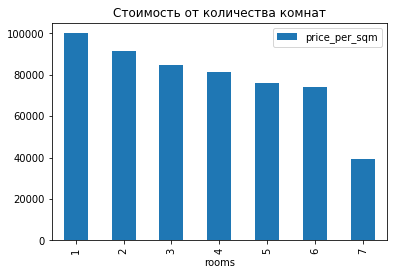

In [68]:
(df.pivot_table(index=['rooms'], values='price_per_sqm', aggfunc='median')
 .plot(kind='bar', title = 'Стоимость от количества комнат'))

На графике зависимости стоимости от расстояния до центра виден нисходящий тренд, однако неявный, так как есть большой разброс стоимости и влияние других факторов:

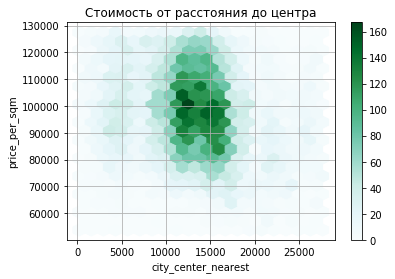

In [69]:
(df.query('price_per_sqm < @price_per_sqm_qntl and price_per_sqm > @price_per_sqm_qntu and city_сenter_nearest < @city_сenter_nearest_qnt')
 .plot(x='city_сenter_nearest', y='price_per_sqm', kind='hexbin', gridsize=20, sharex=False, grid=True, title = 'Стоимость от расстояния до центра'))

Ожидаемо, стоимость квартир на первом и последнем этаже ниже, чем на остальных: 

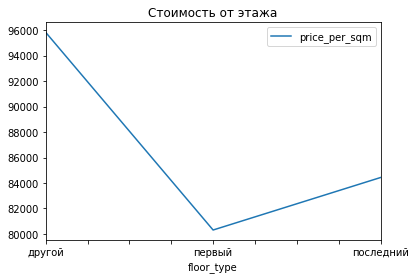

In [70]:
df.pivot_table(index=['floor_type'], values='price_per_sqm', aggfunc='median').plot(kind='line', title = 'Стоимость от этажа')

На графиках ниже видно, что, несмотря на разное количество публикаций в разные дни, месяцы и годы, средняя стоимость квадратного метра почти не отличается:

<font color='blue'>Как мы увидели на линейных графиках, все же отличается, но я тебя понял, в общих выводах ты это упомянул.

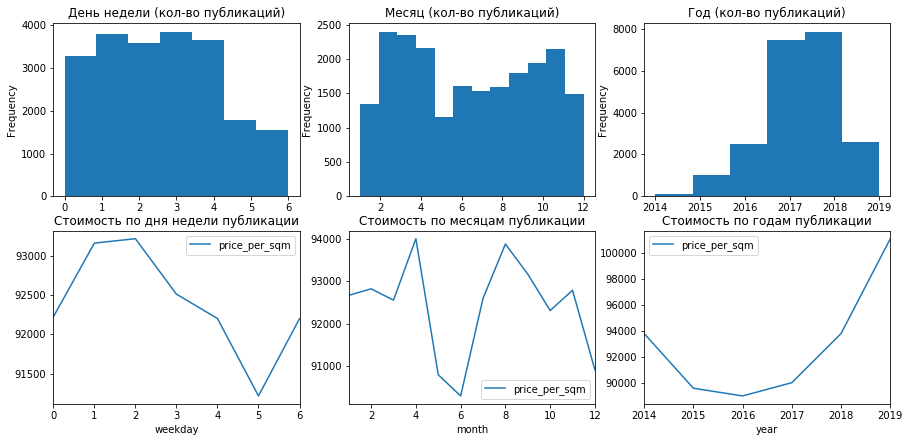

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
df['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
df['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
df['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
df.pivot_table(index=['weekday'], values='price_per_sqm', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'Стоимость по дня недели публикации');
df.pivot_table(index=['month'], values='price_per_sqm', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Стоимость по месяцам публикации');
df.pivot_table(index=['year'], values='price_per_sqm', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Стоимость по годам публикации');

Выделяю топ-10 населенных пунктов:  
- по количеству объявлений:

In [72]:
(df.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'median'])
 .sort_values(by=('count','price_per_sqm'),ascending = False).round().head(10))

,count,median
,price_per_sqm,price_per_sqm
locality_name,,
Санкт-Петербург,13700,101852.0
Мурино,587,86111.0
Кудрово,470,95555.0
Шушары,439,76829.0
Всеволожск,394,65738.0
Пушкин,338,98326.0
Колпино,335,74722.0
Парголово,326,91580.0


- по медианной стоимости квадратного метра:

In [73]:
(df.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'median'])
 .sort_values(by=('median','price_per_sqm'),ascending = False).round().head(10))

,count,median
,price_per_sqm,price_per_sqm
locality_name,,
Санкт-Петербург,13700,101852.0
Зеленогорск,22,98596.0
Пушкин,338,98326.0
Сестрорецк,170,98129.0
Левашово,1,96998.0
Кудрово,470,95555.0
Парголово,326,91580.0
Мистолово,11,90889.0


- по медианной стоимости квадратного метра (последние 10):

In [74]:
(df.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'median'])
 .sort_values(by=('median','price_per_sqm')).round().head(10))

,count,median
,price_per_sqm,price_per_sqm
locality_name,,
Старополье,3,11000.0
станции Свирь,2,11481.0
Вахнова Кара,1,11688.0
Выскатка,2,12335.0
Совхозный,2,12629.0
Малая Романовка,1,12725.0
Тёсово-4,1,12931.0
Бор,1,13158.0


Выводы из рейтингов населенных пунктов:  
- Наибольшее количество объявлений и наивысшая медианная стоимость (ожидаемо) в самом Петербурге
- В топ-10 по стоимости попало несколько населенных пунктов с небольшим количеством, эти данные могут быть не совсем репрезентативны
- Среди населенных пунктов с наинизшей стоимостью различные маленькие пункты с 1-3 объявлениями, то есть хвост данных.

<font color='green'>Хорошо.

#### Расстояние до центра

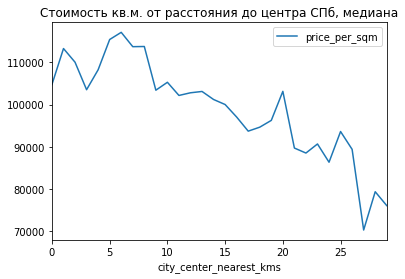

In [75]:
df['city_сenter_nearest_kms'] = (df['city_сenter_nearest']/1000).round()

(df[df['locality_name'] == 'Санкт-Петербург']
 .pivot_table(index=['city_сenter_nearest_kms'], values='price_per_sqm', aggfunc='median')
 .plot(kind='line', title = 'Стоимость кв.м. от расстояния до центра СПб, медиана'))

Судя по графику, максимальная стоимость квадратного метра в Санкт-Петербурге свойственна квартирам в пределах 8 километров от центра, после чего она постепенно снижается. 

In [76]:
df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb_cntr = df.query('locality_name == "Санкт-Петербург" and city_сenter_nearest_kms <= 8')

#### Анализ квартир в центре Петербурга  
Сравниваю два графика: только для центра Петербурга и для всего города с пригородами, по 4 параметрам: цена, площадь, количество комнат, высота потолков.  
Центр Петербурга:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fa34c8208>,
      dtype=object)

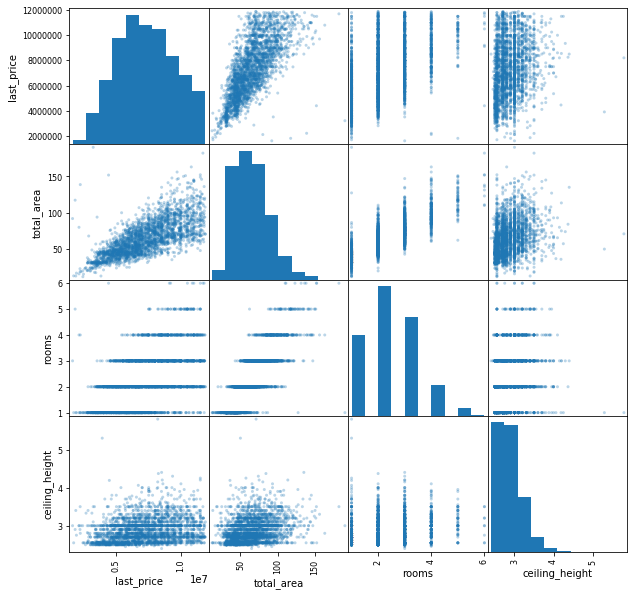

In [77]:
pd.plotting.scatter_matrix(df_spb_cntr.loc[:,['last_price','total_area','rooms','ceiling_height']], 
                           figsize=(10, 10), alpha = 0.3)

Весь город и пригороды:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fa8160588>,
      dtype=object)

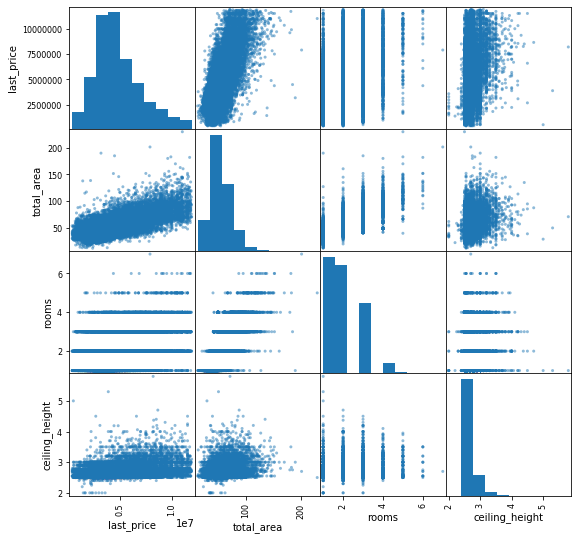

In [78]:
pd.plotting.scatter_matrix(df.loc[:,['last_price','total_area','rooms','ceiling_height']], figsize=(9, 9), alpha = 0.5)

То же, но цифрами:

In [79]:
df_spb_cntr.loc[:,['last_price','total_area','rooms','ceiling_height']].corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.702012,0.488494,0.217626
total_area,0.702012,1.000000,0.809056,0.276776
rooms,0.488494,0.809056,1.000000,0.215660
ceiling_height,0.217626,0.276776,0.215660,1.000000


In [80]:
df.loc[:,['last_price','total_area','rooms','ceiling_height']].corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.696995,0.450040,0.371381
total_area,0.696995,1.000000,0.802771,0.275251
rooms,0.450040,0.802771,1.000000,0.072809
ceiling_height,0.371381,0.275251,0.072809,1.000000


Выводы по матрице корреляции основных параметров:
- сильная связь (>0,7) есть между площадью и ценой (0,7), площадью и количеством комнат (0,8). 
- что интересно, между количеством комнат и ценой связь гораздо слабее (0,5), что говорит о том, что эти показатели связывает площадь.
- эти связи почти одинаковые и для центра, и для Петербурга с пригородами. Разница между матрицами корреляции есть только для пары высота потолка-цена (0,37 vs 0,22), но она не статистически значима. Она возникает потому, что высокие потолки, в основном, в центре Петербурга, где и более дорогие квартиры, поэтому для всей популяции есть слабая связь, а внутри центра все квартиры стоят примерно одинаково (потому что так и определен центр города для анализа).  
  

Выводы по графикам основных параметров более информативны:
- в центре города более одинаковая архитектура, чем во всем городе с пригородами: например, количество комнат более явно коррелирует с площадью, так как почти нет домов со свободной планировкой или маленьких студий;
- в отличие от всего города с пригородами, в центре нет дешевых просторных квартир, все дешевые квартиры меньше 50 кв.м., а разброс по площади есть только у дорогих квартир;
- мода графика квартир в центре дальше от минимальных значений, чем в городе с пригородами, то есть в центре гораздо меньше бюджетного жилья    
- в центре более высокие потолки: заметна доля квартир с потолком выше 3 метров

Как уже было заметно при определении того, что считать центром, стоимость квадратного метра не снижается вплоть до расстояния в 8 километров от центра, что отличается от общей популяции:

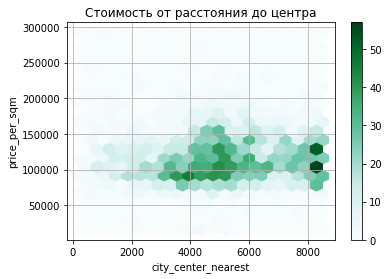

In [81]:
(df_spb_cntr.plot(x='city_сenter_nearest', y='price_per_sqm', kind='hexbin', 
gridsize=20, sharex=False, grid=True, title = 'Стоимость от расстояния до центра'))

Как и везде, стоимость квартир на первом и последнем этаже ниже, чем на остальных: 

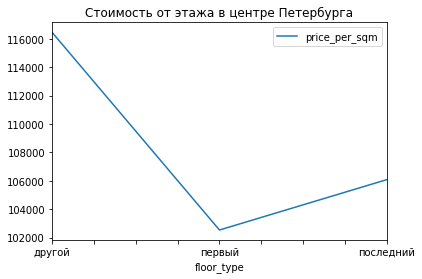

In [82]:
(df_spb_cntr.pivot_table(index=['floor_type'], values='price_per_sqm', aggfunc='median')
 .plot(kind='line', title = 'Стоимость от этажа в центре Петербурга'))

Распределение количества публикаций в центре такое же, как и везде, с чуть более хаотичным распределением за счет меньшего количества объявлений. Однако видно, что время, которое объявление бюыло открыто, выше для квартир в центре города, чем в целом.

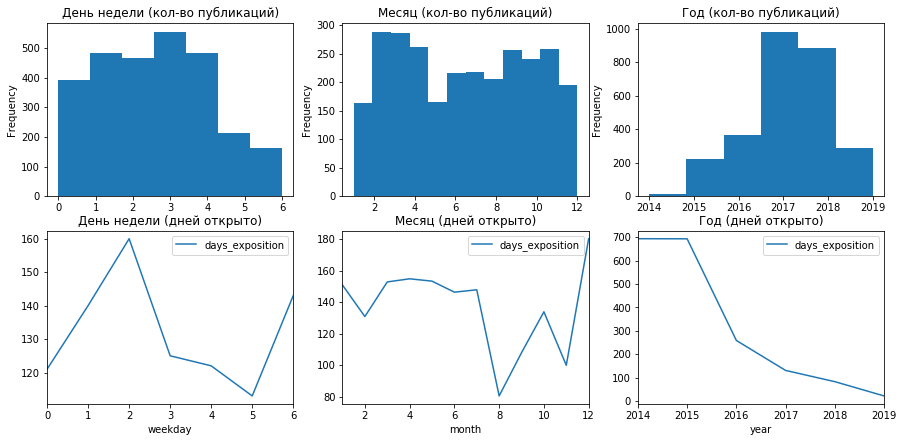

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,7))
df_spb_cntr['weekday'].plot(kind='hist', ax=axes[0, 0], bins = 7, title = 'День недели (кол-во публикаций)');
df_spb_cntr['month'].plot(kind='hist', ax=axes[0, 1], bins = 12, title = 'Месяц (кол-во публикаций)');
df_spb_cntr['year'].plot(kind='hist', ax=axes[0, 2], bins = 6, title = 'Год (кол-во публикаций)');
df_spb_cntr.pivot_table(index=['weekday'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 0], title = 'День недели (дней открыто)');
df_spb_cntr.pivot_table(index=['month'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 1], title = 'Месяц (дней открыто)');
df_spb_cntr.pivot_table(index=['year'], values='days_exposition', aggfunc='median').plot(kind='line', ax=axes[1, 2], title = 'Год (дней открыто)');

Выводы, сделанные по графикам выше, можно подкрепить цифрами (для показательности добавлены данные для Петербурга в целом):

In [84]:
comparison = pd.DataFrame(data={
    'Показатели': ['Количество объявлений','Медианное время жизни объявления', 'Медианная стоимость квартиры', 'Медианная стоимость кв.м.', 'Средняя площадь', 'Средняя высота потолка', 'Средняя этажность здания'], 
    'Петербург с пригородами': [len(df), df['days_exposition'].median().round(), df['last_price'].median().round(), df['price_per_sqm'].median().round(), df['total_area'].mean().round(0), df['ceiling_height'].mean().round(2), df['floors_total'].mean().round(2)], 
    'Петербург': [len(df_spb), df_spb['days_exposition'].median().round(), df_spb['last_price'].median().round(), df_spb['price_per_sqm'].median().round(), df_spb['total_area'].mean().round(0), df_spb['ceiling_height'].mean().round(2), df_spb['floors_total'].mean().round(2)], 
    'Центр Петербурга': [len(df_spb_cntr), df_spb_cntr['days_exposition'].median().round(), df_spb_cntr['last_price'].median().round(), df_spb_cntr['price_per_sqm'].median().round(), df_spb_cntr['total_area'].mean().round(0), df_spb_cntr['ceiling_height'].mean().round(2), df_spb_cntr['floors_total'].mean().round(2)]})

comparison

,Показатели,Петербург с пригородами,Петербург,Центр Петербурга
0,Количество объявлений,21533.00,13700.00,2758.00
1,Медианное время жизни объявления,106.00,101.00,132.00
2,Медианная стоимость квартиры,4400000.00,5150000.00,7200000.00
3,Медианная стоимость кв.м.,92500.00,101852.00,112424.00
4,Средняя площадь,53.00,55.00,66.00
5,Средняя высота потолка,2.68,2.70,2.88
6,Средняя этажность здания,10.75,11.59,7.49


### Общий вывод
Данные обработаны, нормализованы, расширены дополнительными показателями и проанализированы для всей популяции, только для Петербурга и центра Петербурга.  
Объявления публикуются реже в выходные дни и месяцы праздников и отпусков. В менее активные месяцы и дни средняя стоимость на 3-4% ниже стоимости в более активные периоды. Время жизни объявления отличается в 1,5 раза в зависимости от дня недели публикации (что можно считать случайностью, учитывая среднее в 106 дней = 15 недель), и больше чем в 2 раза в зависимости от месяца публикации. В итоге, в более активные месяцы, хотя размещается больше объявлений по более высокой цене, они еще и закрываются быстрее. Среднее время от публикации до закрытия объявления составляет 101 день в Петербурге, 106 за его пределами, но в центре города оно значительно выше - 132 дня, так как (предположительно) здания нетиповые и более дорогие.  
Анализ показателей по годам не очень релевантен, так как с увеличением количества объявлений на Яндекс.Недвижимости все показатели изменяются в несколько раз.  
Центр города для целей анализа определен радиусом в 8 км.  
  
Другие особенности квартир в центре Петербурга:  
- средняя площадь выше за счет отсутствия маленьких квартир,
- стоимость квадратного метра (112 тыс.руб.) немного выше, чем в Петербурге в целом (102 тыс. руб.) и в городе с пригородами (93 тыс. руб.),
- как результат - медианная стоимость квартиры значительно (на 64%) выше, чем с пригородами;
- в центре в домах меньше этажей, зато выше потолки.  
  
Влияние факторов на стоимость квартиры (квадратного метра):  
- этаж (первый и последний - дешевле),
- населенный пункт (самые дорогие, кроме Петербурга, - Зеленогорск, Пушкин, Сестрорецк), 
- расстояние от центра города напрямую не влияет на стоимость: внутри Петербурга оно имеет определяющее значение, начиная с 8 км от центра, для остальных мест важен сам населенный пункт.
- площадь (чем больше квартира, тем дешевле квадратный метр)
- количество комнат (аналогично площади).